In [2]:
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit_optimization.converters import *
from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
from qiskit_optimization import QuadraticProgram
from qiskit.visualization import plot_histogram
from typing import List, Tuple
import numpy as np
import time

In [3]:
from qiskit_optimization.converters import QuadraticProgramToQubo
conv = QuadraticProgramToQubo(100)

In [4]:
quad = QuadraticProgram()

In [5]:
J = 1
T = 3
MNZT_L = [2,2]
MZT_L = [2,2]
b = []
Dt = []
P = [3,3]
Cj = [2,4] 
CjU = [4,2]
D = [3,4,2] 
ut = []
dt = []
for t in range(1,T+1):
    for j in range(1,J+1):
        b.append("b("+str(j)+","+str(t)+")")
for t in range(1,T+1):
    for j in range(1,J+1):
        ut.append("u("+str(j)+","+str(t)+")")
for t in range(1,T+1):
    for j in range(1,J+1):
        dt.append("d("+str(j)+","+str(t)+")")
time_interval = 1

In [6]:
for x in b:
    quad.binary_var(x)
for x in ut:
    quad.binary_var(x)
for x in dt:
    quad.binary_var(x)
print(quad.prettyprint())


Problem name: 

Minimize
  0

Subject to
  No constraints

  Binary variables (9)
    b(1,1) b(1,2) b(1,3) u(1,1) u(1,2) u(1,3) d(1,1) d(1,2) d(1,3)



In [7]:
linear = dict()
quadratic = dict()

In [8]:
# OBJ FUNCTION
for t in range(1,T+1):
    for j in range(1,J+1):
        term = "b("+str(j)+","+str(t)+")"
        l = list(linear.keys())
        if term in l:
            linear[term] += Cj[j-1]*P[j-1]*time_interval  
        else:
            linear[term] = Cj[j-1]*P[j-1]*time_interval
            
        term = "u("+str(j)+","+str(t)+")"
        
        if term in l:
            linear[term] += CjU[j-1]
        else:
            linear[term] = CjU[j-1]

In [9]:
quad.minimize(linear=linear)

In [10]:
print(quad.prettyprint())

Problem name: 

Minimize
  6*b(1,1) + 6*b(1,2) + 6*b(1,3) + 4*u(1,1) + 4*u(1,2) + 4*u(1,3)

Subject to
  No constraints

  Binary variables (9)
    b(1,1) b(1,2) b(1,3) u(1,1) u(1,2) u(1,3) d(1,1) d(1,2) d(1,3)



In [11]:
c = 0

In [12]:
# constrain 1
for t in range(1,T+1):
    d = {}
    for j in range(1,J+1):
        d["b("+str(j)+","+str(t)+")"] = P[j-1]
    quad.linear_constraint(linear=d, sense="GE",  rhs = D[t-1] , name = 'c'+str(c))
    c+=1

In [13]:
print(quad.prettyprint())

Problem name: 

Minimize
  6*b(1,1) + 6*b(1,2) + 6*b(1,3) + 4*u(1,1) + 4*u(1,2) + 4*u(1,3)

Subject to
  Linear constraints (3)
    3*b(1,1) >= 3  'c0'
    3*b(1,2) >= 4  'c1'
    3*b(1,3) >= 2  'c2'

  Binary variables (9)
    b(1,1) b(1,2) b(1,3) u(1,1) u(1,2) u(1,3) d(1,1) d(1,2) d(1,3)



In [14]:
# constrain 2
for j in range(1,J+1):
    for t in range(1,T+1):
        d = {}
        for k in range(max(t-int(MNZT_L[j-1])+1,1),t+1):
            term = "u("+str(j)+","+str(k)+")"
            d[term] = 1
        d["b("+str(j)+","+str(t)+")"] = -1
        quad.linear_constraint(linear=d, sense="LE",  rhs = 0 , name = 'c'+str(c))
        c+=1

In [15]:
print(quad.prettyprint())

Problem name: 

Minimize
  6*b(1,1) + 6*b(1,2) + 6*b(1,3) + 4*u(1,1) + 4*u(1,2) + 4*u(1,3)

Subject to
  Linear constraints (6)
    3*b(1,1) >= 3  'c0'
    3*b(1,2) >= 4  'c1'
    3*b(1,3) >= 2  'c2'
    -b(1,1) + u(1,1) <= 0  'c3'
    -b(1,2) + u(1,1) + u(1,2) <= 0  'c4'
    -b(1,3) + u(1,2) + u(1,3) <= 0  'c5'

  Binary variables (9)
    b(1,1) b(1,2) b(1,3) u(1,1) u(1,2) u(1,3) d(1,1) d(1,2) d(1,3)



In [16]:
# constrain 3
for j in range(1,J+1):
    for t in range(1,T+1):
        d = {}
        d["b("+str(j)+","+str(t)+")"] = 1
        for k in range(max(t-int(MZT_L[j-1])+1,1),t+1):
            term = "d("+str(j)+","+str(k)+")"
            d[term] = 1
        quad.linear_constraint(linear=d, sense="LE",  rhs = 1 , name = 'c'+str(c))
        c+=1

In [17]:
print(quad.prettyprint())

Problem name: 

Minimize
  6*b(1,1) + 6*b(1,2) + 6*b(1,3) + 4*u(1,1) + 4*u(1,2) + 4*u(1,3)

Subject to
  Linear constraints (9)
    3*b(1,1) >= 3  'c0'
    3*b(1,2) >= 4  'c1'
    3*b(1,3) >= 2  'c2'
    -b(1,1) + u(1,1) <= 0  'c3'
    -b(1,2) + u(1,1) + u(1,2) <= 0  'c4'
    -b(1,3) + u(1,2) + u(1,3) <= 0  'c5'
    b(1,1) + d(1,1) <= 1  'c6'
    b(1,2) + d(1,1) + d(1,2) <= 1  'c7'
    b(1,3) + d(1,2) + d(1,3) <= 1  'c8'

  Binary variables (9)
    b(1,1) b(1,2) b(1,3) u(1,1) u(1,2) u(1,3) d(1,1) d(1,2) d(1,3)



In [18]:
# CONSTRAIN 4
for j in range(1,J+1):
    term2 = "b("+str(j)+","+str(1)+")"
    term3 = "d("+str(j)+","+str(1)+")"
    term4 = "u("+str(j)+","+str(1)+")"
    quad.linear_constraint(linear={term2:-1 , term3:-1 , term4:1 }, sense="E",  rhs = 0 , name = 'c'+str(c))
    c += 1
    for t in range(2,T+1):
        term1 = "b("+str(j)+","+str(t-1)+")"
        term2 = "b("+str(j)+","+str(t)+")"
        term3 = "d("+str(j)+","+str(t)+")"
        term4 = "u("+str(j)+","+str(t)+")"
        quad.linear_constraint(linear={term1:1 , term2:-1 , term3:-1 , term4:1 }, sense="E",  rhs = 0 , name = 'c'+str(c))
        c += 1

In [19]:
print(quad.prettyprint())

Problem name: 

Minimize
  6*b(1,1) + 6*b(1,2) + 6*b(1,3) + 4*u(1,1) + 4*u(1,2) + 4*u(1,3)

Subject to
  Linear constraints (12)
    3*b(1,1) >= 3  'c0'
    3*b(1,2) >= 4  'c1'
    3*b(1,3) >= 2  'c2'
    -b(1,1) + u(1,1) <= 0  'c3'
    -b(1,2) + u(1,1) + u(1,2) <= 0  'c4'
    -b(1,3) + u(1,2) + u(1,3) <= 0  'c5'
    b(1,1) + d(1,1) <= 1  'c6'
    b(1,2) + d(1,1) + d(1,2) <= 1  'c7'
    b(1,3) + d(1,2) + d(1,3) <= 1  'c8'
    -b(1,1) - d(1,1) + u(1,1) == 0  'c9'
    b(1,1) - b(1,2) - d(1,2) + u(1,2) == 0  'c10'
    b(1,2) - b(1,3) - d(1,3) + u(1,3) == 0  'c11'

  Binary variables (9)
    b(1,1) b(1,2) b(1,3) u(1,1) u(1,2) u(1,3) d(1,1) d(1,2) d(1,3)



In [20]:
qubo = conv.convert(quad)

In [21]:
print(qubo.prettyprint())

Problem name: 

Minimize
  1100*b(1,1)^2 - 200*b(1,1)*b(1,2) + 300*b(1,1)*d(1,1) - 200*b(1,1)*d(1,2)
  - 300*b(1,1)*u(1,1) + 200*b(1,1)*u(1,2) + 1200*b(1,2)^2 - 200*b(1,2)*b(1,3)
  - 200*b(1,2)*c4@int_slack@0 + 100*b(1,2)*d(1,1) + 300*b(1,2)*d(1,2)
  - 200*b(1,2)*d(1,3) - 200*b(1,2)*u(1,1) - 400*b(1,2)*u(1,2)
  + 200*b(1,2)*u(1,3) + 1100*b(1,3)^2 - 600*b(1,3)*c2@int_slack@0
  - 200*b(1,3)*c5@int_slack@0 + 100*b(1,3)*d(1,2) + 300*b(1,3)*d(1,3)
  - 200*b(1,3)*u(1,2) - 400*b(1,3)*u(1,3) + 100*c2@int_slack@0^2
  + 100*c4@int_slack@0^2 + 100*c5@int_slack@0^2 + 100*d(1,1)^2
  + 100*d(1,1)*d(1,2) + 100*d(1,2)^2 + 100*d(1,2)*d(1,3) + 100*d(1,3)^2
  + 200*u(1,1)*c4@int_slack@0 - 200*u(1,1)*d(1,1) + 200*u(1,1)^2
  + 200*u(1,1)*u(1,2) + 200*u(1,2)*c4@int_slack@0 + 200*u(1,2)*c5@int_slack@0
  - 200*u(1,2)*d(1,2) + 300*u(1,2)^2 + 200*u(1,2)*u(1,3)
  + 200*u(1,3)*c5@int_slack@0 - 200*u(1,3)*d(1,3) + 200*u(1,3)^2 - 1794*b(1,1)
  - 2394*b(1,2) - 1194*b(1,3) + 400*c2@int_slack@0 + 104*u(1,1) + 4*u(1,2)

In [22]:
from qiskit_optimization.algorithms import CplexOptimizer
start_time = time.time()
result = CplexOptimizer().solve(qubo)
end_time = time.time()
print(result.prettyprint())
execution_time = end_time - start_time
print(execution_time)

objective function value: 122.0
variable values: b(1,1)=1.0, b(1,2)=1.0, b(1,3)=1.0, u(1,1)=1.0, u(1,2)=0.0, u(1,3)=0.0, d(1,1)=0.0, d(1,2)=0.0, d(1,3)=0.0, c2@int_slack@0=1.0, c4@int_slack@0=0.0, c5@int_slack@0=1.0
status: SUCCESS
0.029327392578125


In [23]:
from qiskit_ibm_runtime import QiskitRuntimeService

In [24]:
service = QiskitRuntimeService(channel='ibm_quantum',token='560fe958fb9696b957775ecbddd4d5bf9917279444e02b74463bc1d09a7c7b18daa0d5361d0e7d9e14ab57013d946d87c6acedeeb531a0897a6fda6eb2f699d8')

# Simple QAOA

In [46]:
from qiskit.primitives import BackendSampler,Sampler
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [47]:
from qiskit_aer import AerSimulator

In [48]:
# idea 'free of noise' simultor 
aerSimulator = AerSimulator()

In [49]:
backendSampler = BackendSampler(backend=aerSimulator,options={'shots':5000},skip_transpilation = False)

C:\Users\user\AppData\Local\Temp\ipykernel_27876\2990836854.py:1: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  backendSampler = BackendSampler(backend=aerSimulator,options={'shots':5000},skip_transpilation = False)


In [50]:
qaoa_mes = QAOA(sampler = backendSampler, optimizer=COBYLA(),reps=3)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qubo)

In [51]:
result

<MinimumEigenOptimizationResult: fval=122.0, b(1,1)=1.0, b(1,2)=1.0, b(1,3)=1.0, u(1,1)=1.0, u(1,2)=0.0, u(1,3)=0.0, d(1,1)=0.0, d(1,2)=0.0, d(1,3)=0.0, c2@int_slack@0=1.0, c4@int_slack@0=0.0, c5@int_slack@0=1.0, status=SUCCESS>

# Presentations

In [75]:
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import matplotlib.pyplot as plt

In [76]:
dict_shots = dict()

In [77]:
aerSimulator = AerSimulator()

In [78]:
shots = [1000,2000,3000,4000,5000,6000,7000,8000]
proba = []
avg_fval = []
for shot in shots:
    # idea 'free of noise' simultor 
    aerSimulator = AerSimulator()
    sampler = BackendSampler(backend=aerSimulator,options={'shots':shot},skip_transpilation=False)
    qaoa_mes = QAOA(sampler = sampler, optimizer=COBYLA(),reps=2)
    qaoa = MinimumEigenOptimizer(qaoa_mes)
    result = qaoa.solve(qubo)
    total = 0
    total_proba = 0
    for x in result.samples:
        total += x.fval*x.probability
        if x.fval == 122.0:
            total_proba += x.probability
    dict_shots[shot] = result
    avg_fval.append(total)
    proba.append(total_proba)

C:\Users\user\AppData\Local\Temp\ipykernel_27876\3520372507.py:7: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler = BackendSampler(backend=aerSimulator,options={'shots':shot},skip_transpilation=False)
C:\Users\user\AppData\Local\Temp\ipykernel_27876\3520372507.py:7: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler = BackendSampler(backend=aerSim

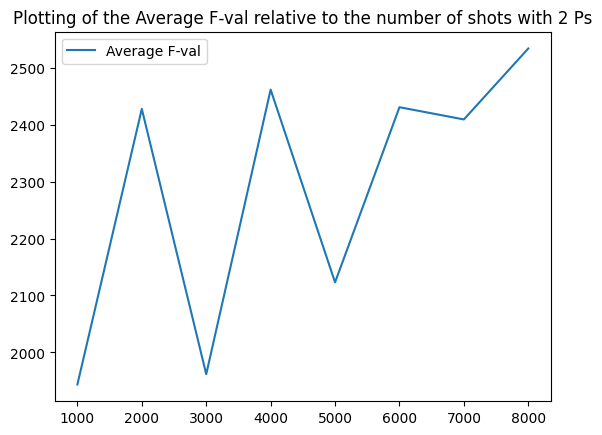

In [79]:
plt.plot(shots, avg_fval, label='Average F-val')
plt.title('Plotting of the Average F-val relative to the number of shots with 2 Ps')
plt.legend()
plt.show()

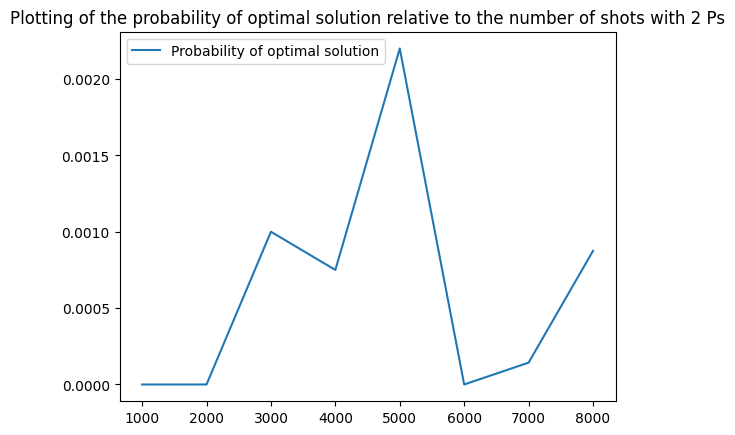

In [80]:
plt.plot(shots, proba, label='Probability of optimal solution')
plt.title('Plotting of the probability of optimal solution relative to the number of shots with 2 Ps')
plt.legend()
plt.show()

In [84]:
dict_ps = dict()

In [85]:
avg_fval = []
proba = []
p = [1,2,3,4,5,6]
for rep in p:
    sampler = BackendSampler(backend=aerSimulator,options={'shots':5000})
    qaoa_mes = QAOA(sampler = sampler, optimizer=COBYLA(),reps=rep)
    qaoa = MinimumEigenOptimizer(qaoa_mes)
    exact_result = qaoa.solve(qubo)
    total = 0
    total_proba = 0
    for x in exact_result.samples:
        total += x.fval*x.probability
        if x.fval == 122.0:
            total_proba += x.probability
    avg_fval.append(total)
    dict_ps[rep] = result
    proba.append(total_proba)

C:\Users\user\AppData\Local\Temp\ipykernel_27876\3770472825.py:5: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler = BackendSampler(backend=aerSimulator,options={'shots':5000})
C:\Users\user\AppData\Local\Temp\ipykernel_27876\3770472825.py:5: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler = BackendSampler(backend=aerSimulator,options={'shots':5

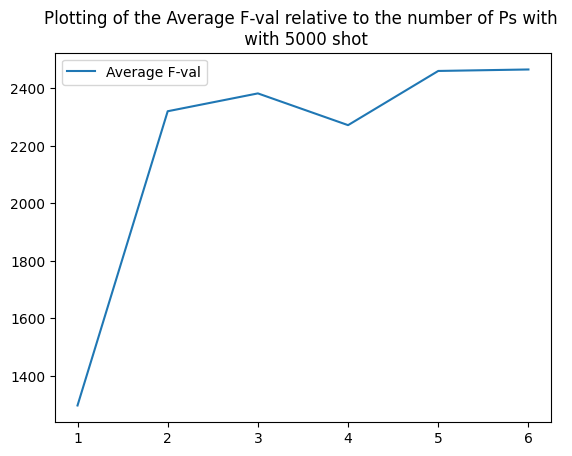

In [86]:
plt.plot(p, avg_fval, label='Average F-val')
plt.title('Plotting of the Average F-val relative to the number of Ps with \n with 5000 shot')
plt.legend()
plt.show()

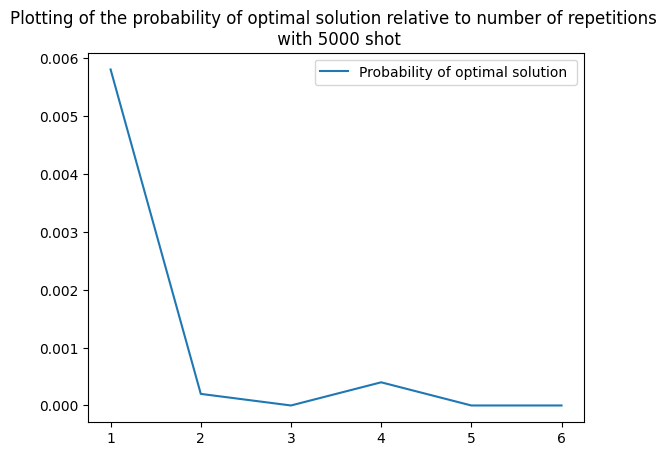

In [87]:
plt.plot(p, proba, label='Probability of optimal solution ')
plt.title('Plotting of the probability of optimal solution relative to number of repetitions \n with 5000 shot')
plt.legend()
plt.show()

In [88]:
dict_ps[1].samples

[SolutionSample(x=array([1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.]), fval=122.0, probability=0.000875, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.]), fval=218.0, probability=0.00025, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.]), fval=222.0, probability=0.00025, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.]), fval=222.0, probability=0.000125, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.]), fval=222.0, probability=0.00025, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0.]), fval=226.0, probability=0.003125, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0.

# Try on device simulator

In [96]:
from qiskit.primitives import BackendSampler
from qiskit_ibm_runtime.fake_provider import FakeKyoto

In [97]:
back = FakeKyoto()

In [98]:
fake_back = AerSimulator.from_backend(back)

In [99]:
Fake_sampler = BackendSampler(backend=fake_back,options={'shots':2500})

C:\Users\user\AppData\Local\Temp\ipykernel_27876\2663046784.py:1: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  Fake_sampler = BackendSampler(backend=fake_back,options={'shots':2500})


In [100]:
qaoa_mes = QAOA(sampler = Fake_sampler, optimizer=COBYLA(),reps=1)

In [101]:
qaoa = MinimumEigenOptimizer(qaoa_mes)

In [102]:
real_r = qaoa.solve(qubo)

In [110]:
real_r.samples

[SolutionSample(x=array([1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.]), fval=122.0, probability=0.0004, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.]), fval=222.0, probability=0.0004, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.]), fval=222.0, probability=0.0004, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0.]), fval=226.0, probability=0.0012, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.]), fval=318.0, probability=0.0004, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.]), fval=318.0, probability=0.0008, status=<OptimizationResultStatus.SUCCESS: 0>),
 SolutionSample(x=array([1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0.]), f

In [106]:
average_device = 0

In [107]:
for x in real_r.samples:
    average_device += x.fval*x.probability
average_device

2533.0423999999925

In [109]:
average_device

2533.0423999999925

In [113]:
probability_device = real_r.samples[0].probability

In [114]:
probability_device

0.0004

# Basic simulator

In [137]:
sampler = BackendSampler(aerSimulator,options={'shots':5000})

C:\Users\user\AppData\Local\Temp\ipykernel_27876\2243601488.py:1: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler = BackendSampler(aerSimulator,options={'shots':5000})


In [138]:
qaoa_mes = QAOA(sampler = sampler, optimizer=COBYLA(),reps=1)

In [139]:
qaoa = MinimumEigenOptimizer(qaoa_mes)

In [140]:
normal_result = qaoa.solve(qubo)

In [141]:
probability_normal_simu = normal_result.samples[0].probability

In [142]:
average_simulator_normal = 0

In [143]:
for x in normal_result.samples:
    average_simulator_normal += x.fval*x.probability

In [144]:
average_simulator_normal

1221.288000000002

In [145]:
import matplotlib.pyplot as plt

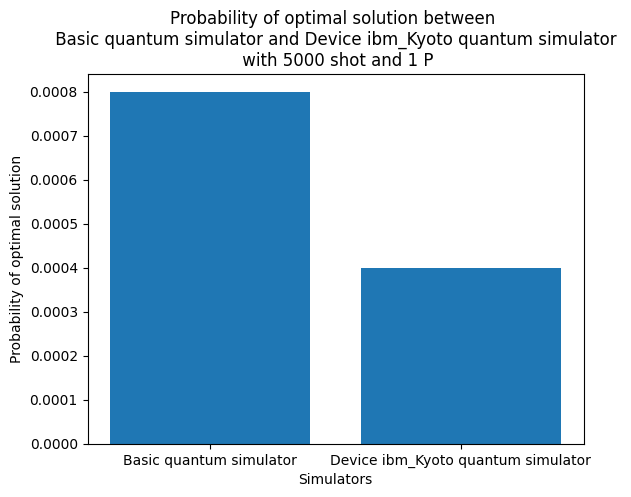

In [146]:
x_labels = ['Basic quantum simulator', 'Device ibm_Kyoto quantum simulator']
bar_heights = [probability_normal_simu, probability_device]
plt.bar(x_labels, bar_heights)

plt.xlabel('Simulators')
plt.ylabel('Probability of optimal solution')
plt.title('Probability of optimal solution between \n Basic quantum simulator and Device ibm_Kyoto quantum simulator \n with 5000 shot and 1 P')

plt.show()

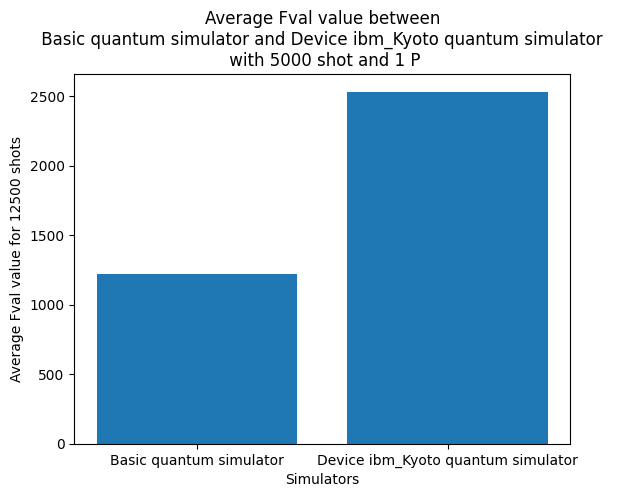

In [148]:
x_labels = ['Basic quantum simulator', 'Device ibm_Kyoto quantum simulator']
bar_heights = [average_simulator_normal, average_device]
plt.bar(x_labels, bar_heights)

plt.xlabel('Simulators')
plt.ylabel('Average Fval value for 12500 shots')
plt.title('Average Fval value between\n Basic quantum simulator and Device ibm_Kyoto quantum simulator \n with 5000 shot and 1 P')

plt.show()

# Run on real Quantum

In [184]:
from qiskit.primitives import backend_estimator,backend_sampler

In [152]:
real_b = service.get_backend('ibm_kyoto')

C:\Users\user\AppData\Local\Temp\ipykernel_27876\2336305202.py:1: DeprecationWarning: The get_backend() method is deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use backend() instead.
  real_b = service.get_backend('ibm_kyoto')


In [153]:
back = BackendSampler(real_b,options={'shots':5000})

C:\Users\user\AppData\Local\Temp\ipykernel_27876\2153535366.py:1: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  back = BackendSampler(real_b,options={'shots':5000})


In [154]:
qaoa_mes = QAOA(sampler = back, optimizer=COBYLA(),reps=1)

In [155]:
qaoa = MinimumEigenOptimizer(qaoa_mes)

In [156]:
qaoa.solve(qubo)

KeyboardInterrupt: 

# Real quantum results

In [37]:
import matplotlib.pyplot as plt

In [25]:
job = service.job('cv6dgd9mzw7000846rcg')

In [26]:
result = job.result()

In [27]:
counts_dict = result.get_counts()

In [28]:
mn = 1e10

In [29]:
proba_of_real_qc = 0

In [30]:
avg_fval_real_qc = 0

In [31]:
for posi in counts_dict:
    bits = [int(b) for b in posi]
    v = qubo.objective.evaluate(bits)
    avg_fval_real_qc += v*counts_dict[posi]
    if v == 122.0:
        proba_of_real_qc += 1

In [32]:
proba_of_real_qc = proba_of_real_qc/5000

In [33]:
avg_fval_real_qc = avg_fval_real_qc/5000

In [34]:
avg_fval_real_qc

2557.4812

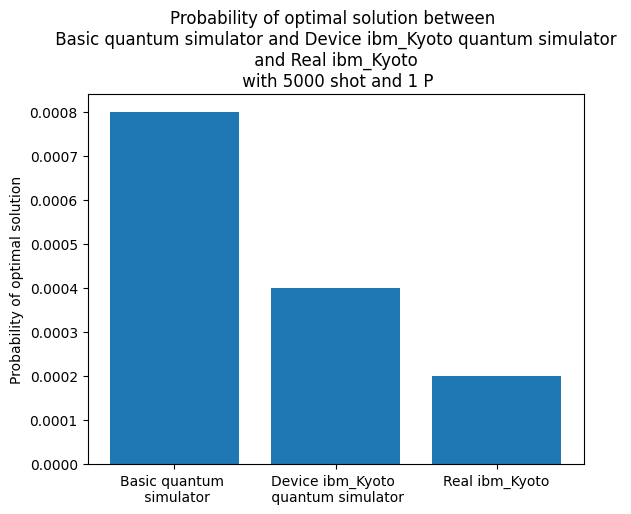

In [38]:
x_labels = ['Basic quantum \n simulator', 'Device ibm_Kyoto \n quantum simulator','Real ibm_Kyoto']
bar_heights = [0.0008, 0.0004,proba_of_real_qc]
plt.bar(x_labels, bar_heights)

plt.ylabel('Probability of optimal solution')
plt.title('Probability of optimal solution between \n Basic quantum simulator and Device ibm_Kyoto quantum simulator \n and Real ibm_Kyoto \n with 5000 shot and 1 P')

plt.show()

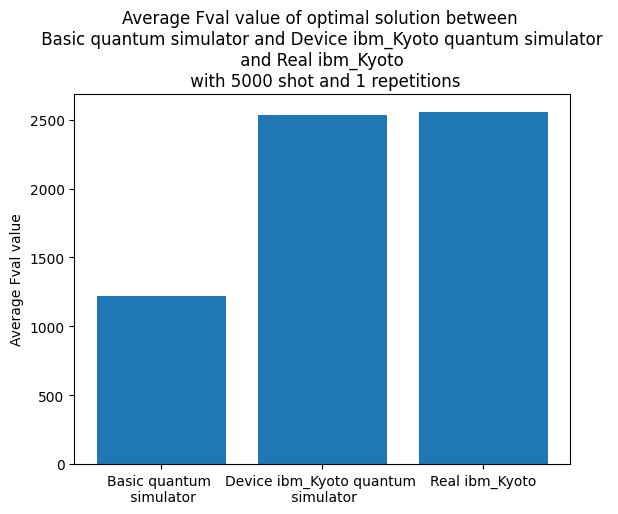

In [39]:
x_labels = ['Basic quantum \n simulator', 'Device ibm_Kyoto quantum \n simulator','Real ibm_Kyoto']
bar_heights = [1221.288000000002, 2533.0423999999925,avg_fval_real_qc]
plt.bar(x_labels, bar_heights)

plt.ylabel('Average Fval value')
plt.title('Average Fval value of optimal solution between \n Basic quantum simulator and Device ibm_Kyoto quantum simulator \n and Real ibm_Kyoto \n with 5000 shot and 1 repetitions')

plt.show()